# **Healthcare: Opioid Analysis**

<body>
<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F5dbb4182d85e3000078fddae%2F0x0.jpg"/>
</body>

**Alpha Insurance is a large corporate Insurance firm based in the USA. Specialising in Healthcare insurance for large hospitals and practices they have set a name for themselves in the Healthcare Insurance sector. Alpha Insurance has been receiving  a lot of healthcare claims due to a recent Opioid epidemic. To battle this, the company wants to be aware of which healthcare professions are more likely to prescribe opioids. This way they can offer further advice to the potential client and be aware of a potential risk before it happens.**


***Having collected data of healthcare practices around the US from the CMS, Alpha Insurance want you to come up with a prediction system to identify potential opioid prescribing practices.***

## **1. Import Libraries and Data needed**
<body>
<img src="https://offloadmedia.feverup.com/secretldn.com/wp-content/uploads/2016/06/18075319/Libraries-1024x901.jpg" width="500"/>
</body>

Here we are importing all the libraries that we will need to analyse the data.

Libraries contain all the little functions and tools that other programmers have created. This way we don't have to spend hours recreating code. Instead, we just call out the function name and it performs all the steps we want it to do.

In [1]:
import pandas as pd
#Importing all modules here
import os
import sys
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn import metrics
%pylab inline

import re
from bokeh.io import output_notebook
from bokeh.sampledata import us_states
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.palettes import brewer
from bokeh.models import HoverTool, Range1d
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)

Populating the interactive namespace from numpy and matplotlib


Load in the data...

In [2]:
Prescriber = pd.read_csv(r"https://raw.githubusercontent.com/ssonkol/Medication_Prediction/master/Healthcare%20Analysis%20Tutorial/prescriber-info.csv", header=0, sep=",", nrows = 10000000)
overdoses = pd.read_csv(r"https://raw.githubusercontent.com/ssonkol/Medication_Prediction/master/Healthcare%20Analysis%20Tutorial/overdoses.csv", header=0, sep=",", nrows = 10000000)
opioids = pd.read_csv(r"https://raw.githubusercontent.com/ssonkol/Medication_Prediction/master/Healthcare%20Analysis%20Tutorial/opioids.csv", header=0, sep=",", nrows = 10000000)

### **Check The Data**

What looks interesting in the table?
What predictions can you potentially make with this data?

In [3]:
Prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,...,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,...,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


In [ ]:
overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [ ]:
opioids

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN
...,...,...
108,XODOL 7.5-300,HYDROCODONE/ACETAMINOPHEN
109,XYLON 10,HYDROCODONE/IBUPROFEN
110,ZAMICET,HYDROCODONE/ACETAMINOPHEN
111,ZOHYDRO ER,HYDROCODONE BITARTRATE


## **2. Set Up The Model**

<body>
<img src="https://beyondtheory.co.uk/storage/images/other/2016/08/Beyond-Theory-Data-Analysis-Landing-Page-graphic.png" width="800"/>
</body>

In this example, we are creating a predictive model for dentists.


*   X is the data the model looks at to make a prediction
*   Y is the data the model looks at to see if its prediction was correct

Note: 

1 = opioid prescriber


0 = not an opioid prescriber







In [ ]:
#Select our specialty
dentists = Prescriber[Prescriber['Specialty'] == 'Dentist']

dentists['Gender'] = pd.get_dummies(dentists['Gender'])

target = 'Opioid.Prescriber'
X = dentists.drop(['Gender','NPI', 'Specialty', 'Credentials', 'State', target], 1)
y = dentists[target]
(X.shape, y.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


((966, 250), (966,))

Now let us take a look at the data!

In [ ]:
X.head()

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,...,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our training data essentially contains a tally of all drug prescriptions made per medical specialist. As you can see, the specialists gender,npi, specialty, credentials and state has been taken out. 

This is because we don't want the model to take these factors into account - only the list of drug names should be attributed to the specialty.

As for our y data, we are only looking at whether or not the specialist is an opioid prescriber.

In [ ]:
y.head()

0     1.0
19    1.0
29    0.0
43    0.0
45    0.0
Name: Opioid.Prescriber, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
alg = xgb.XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=4,
        objective="binary:logistic",
        scale_pos_weight=1,
        seed=27) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Text(0, 0.5, 'Feature Importance Score')

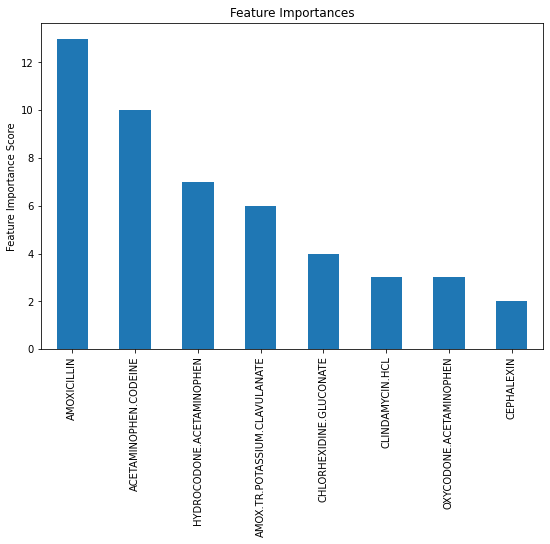

In [ ]:
#xgBoost Model
metrics = ['auc', 'map']
xgtrain = xgb.DMatrix(X_train,y_train)#takes in x and y variables
param = alg.get_xgb_params()
cvresult = xgb.cv(param,
                  xgtrain,
                  num_boost_round=alg.get_params()['n_estimators'],
                  nfold=7,
                  metrics=metrics,
                  early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])
#Predict training set:
alg.fit(X_train,y_train,eval_metric=metrics)
xgbooSt = alg.fit(X_train,y_train,eval_metric=metrics)
# Show features, rated by fscore
features = alg._Booster.get_fscore()
feat_imp = pd.Series(features).sort_values(ascending=False)
feat_imp[:50].plot(kind='bar', title='Feature Importances', figsize=(9,6))
plt.ylabel('Feature Importance Score')

## **3. Model Review**

<body>
<img src="https://t3.ftcdn.net/jpg/03/28/54/50/360_F_328545004_Q7tujNu0VpoTXUqlGad4LyEVxpNSeoYu.jpg"/>
</body>


In [ ]:
# sort for human readability
import operator
sorted_features = sorted(features.items(), key=operator.itemgetter(1))
print('features by importance', sorted_features)

features by importance [('CEPHALEXIN', 2), ('OXYCODONE.ACETAMINOPHEN', 3), ('CLINDAMYCIN.HCL', 3), ('CHLORHEXIDINE.GLUCONATE', 4), ('AMOX.TR.POTASSIUM.CLAVULANATE', 6), ('HYDROCODONE.ACETAMINOPHEN', 7), ('ACETAMINOPHEN.CODEINE', 10), ('AMOXICILLIN', 13)]


Accuracy : 0.9215
AUC Score (Train): 0.929932


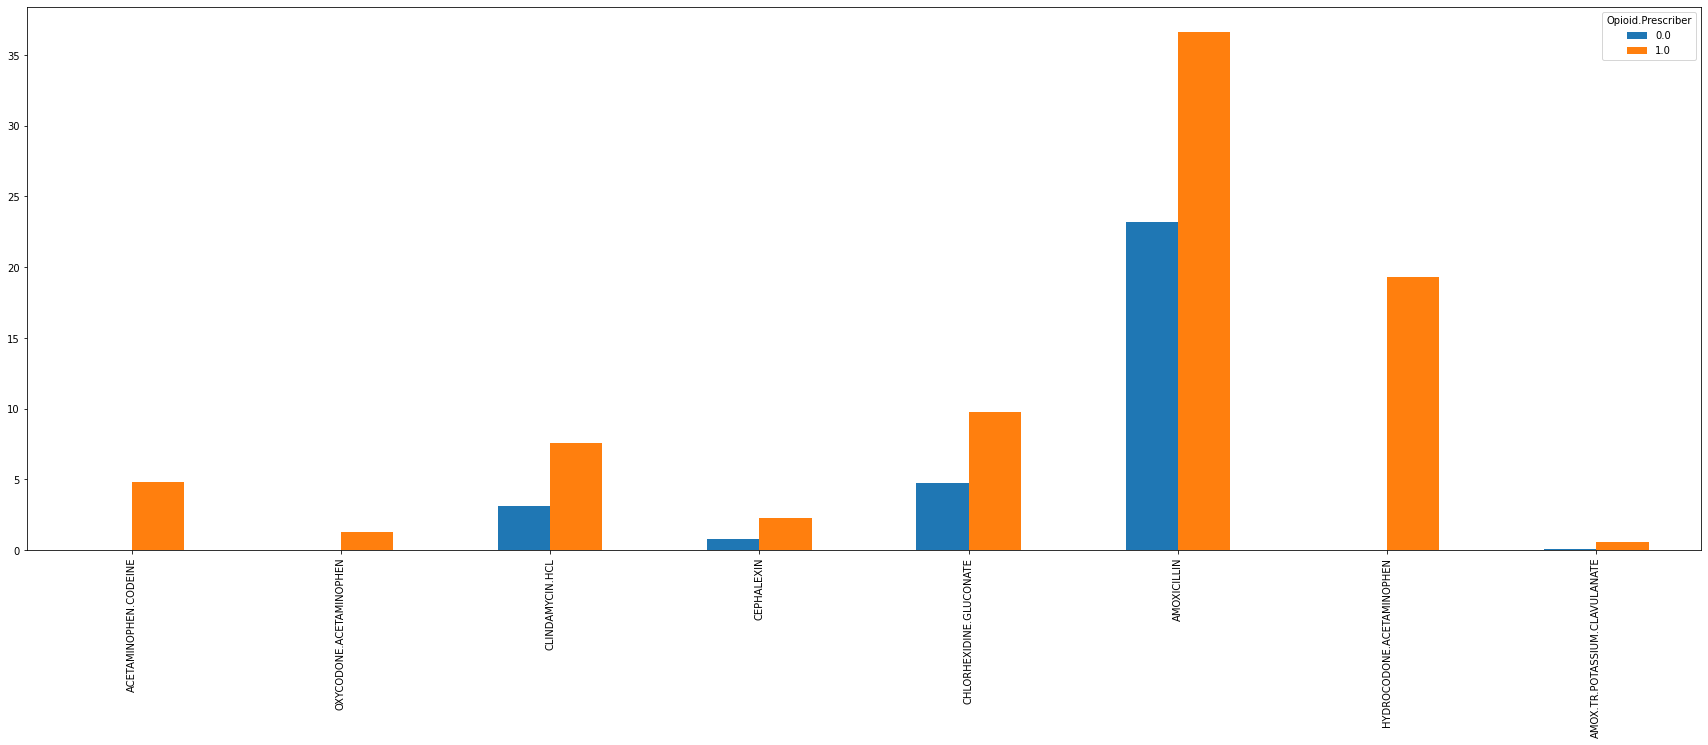

In [ ]:
from sklearn import metrics
pred = alg.predict(X_test)
predprob = alg.predict_proba(X_test)[:,1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, pred))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, predprob))
mean_dentists = dentists.groupby('Opioid.Prescriber').mean()
relevant_stats = [mean_dentists[feature] for feature in features]
pd.DataFrame(relevant_stats).plot(kind="bar", figsize=(30,10))

In [ ]:
top_features = list(features.keys())
top_features

['ACETAMINOPHEN.CODEINE',
 'OXYCODONE.ACETAMINOPHEN',
 'CLINDAMYCIN.HCL',
 'CEPHALEXIN',
 'CHLORHEXIDINE.GLUCONATE',
 'AMOXICILLIN',
 'HYDROCODONE.ACETAMINOPHEN',
 'AMOX.TR.POTASSIUM.CLAVULANATE']

##**Things To Try**

Copy one of the specialties from the list below and apply it to the code where we selected a specialty.

* What drugs are they more likely to prescribe?
*   Are these Opioids?
*   Therefore, are they more likely to prescribe opioids?





In [ ]:
Prescriber['Specialty'].value_counts()

Internal Medicine                  3194
Family Practice                    2975
Dentist                            2800
Nurse Practitioner                 2512
Physician Assistant                1839
                                   ... 
Midwife                               1
Military Health Care Provider         1
Health Maintenance Organization       1
Unknown Supplier/Provider             1
Behavioral Analyst                    1
Name: Specialty, Length: 109, dtype: int64